###  Implementa um agente com acesso ao yfinance que faz reports sobre as acoes baseado nas datas que voce pedir e plota graficos

# Tools

In [62]:
from langchain_core.tools import tool
import yfinance as yf

@tool
def procurar_dados_acao(ticker: str,data_inicio: str,data_fim: str):
    """
    Argumentos: Ticker da acao, data_inicio e data_fim do periodo de interesse seguindo o formato YYYY-MM-DD
    Retorna: DataFrame pandas com os dados historicos do ativo no periodo escolhido
    """

    ativo = yf.Ticker(ticker=ticker)

    historico = ativo.history(start=data_inicio,end=data_fim,auto_adjust=False)

    return historico



In [63]:
procurar_dados_acao.args

{'ticker': {'title': 'Ticker', 'type': 'string'},
 'data_inicio': {'title': 'Data Inicio', 'type': 'string'},
 'data_fim': {'title': 'Data Fim', 'type': 'string'}}

# Agente e modelo

Coloque sua api_key se quiser rodar

In [ ]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash-lite", model_provider="google_genai",api_key="")
tools_list=[procurar_dados_acao]
model_with_tools = model.bind_tools(tools=tools_list)

In [65]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model, tools=tools_list)

In [66]:
if False:

    input_message = {"role": "user", "content": "Oi!"}
    response = agent_executor.invoke({"messages": [input_message]})

    for message in response["messages"]:
        message.pretty_print()

In [67]:
if False:
    input_message = {"role": "user", "content": "Me fale sobre os dados da acao da petrobras que tem o ticker ""PETR4.SA"" no periodo de 2020-01-01 ate 2020-02-01, descreva como a acao performou no periodo"}
    response = agent_executor.invoke({"messages": [input_message]})

    for message in response["messages"]:
        message.pretty_print()

passando uma query sem falar o ticker

In [68]:
if False:
    input_message = {"role": "user", "content": "Me fale sobre os dados da acao da Apple no periodo de 2020-01-01 ate 2020-02-01, descreva como a acao performou no periodo"}
    response = agent_executor.invoke({"messages": [input_message]})

    for message in response["messages"]:
        message.pretty_print()

ela soube o tikcer da apple, oq eh bom

Vamos tentar fazer ela plotar um grafico, a ideia eh a llm escrever o codigo de plot e usar o df do yfinance como dado. Uma alternativa seria escrever uma tool para plotar o grafico, acho que funcionanria, mas o grafico seria sempre o mesmo, pouco flexivel. Vamos ver se dando um ambiente executavel ela consegue.

!! Tomem cuidado pq o repl executa qualquer coisa que o agente mandar no seu pc

precisa rodar: !pip install -qU langchain_experimental


In [69]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL


python_repl = PythonREPL()

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`. Useful to plot graphs",
    func=python_repl.run,
)

In [70]:
tools_list.append(repl_tool)


In [71]:
tools_list

[StructuredTool(name='procurar_dados_acao', description='Argumentos: Ticker da acao, data_inicio e data_fim do periodo de interesse seguindo o formato YYYY-MM-DD\nRetorna: DataFrame pandas com os dados historicos do ativo no periodo escolhido', args_schema=<class 'langchain_core.utils.pydantic.procurar_dados_acao'>, func=<function procurar_dados_acao at 0x000001F362A85D00>),
 Tool(name='python_repl', description='A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`. Useful to plot graphs', func=<bound method PythonREPL.run of PythonREPL(globals={}, locals={})>)]

In [72]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model, tools=tools_list)


In [75]:
input_message = {"role": "user", "content": "Oi, voce tem acesso as tools?"}

response = agent_executor.invoke({"messages": [input_message]})

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Oi, voce tem acesso as tools?
================================== Ai Message ==================================

Sim, eu tenho acesso a ferramentas que me permitem procurar dados de ações e executar código Python.


Vamos fazer uma analise completa

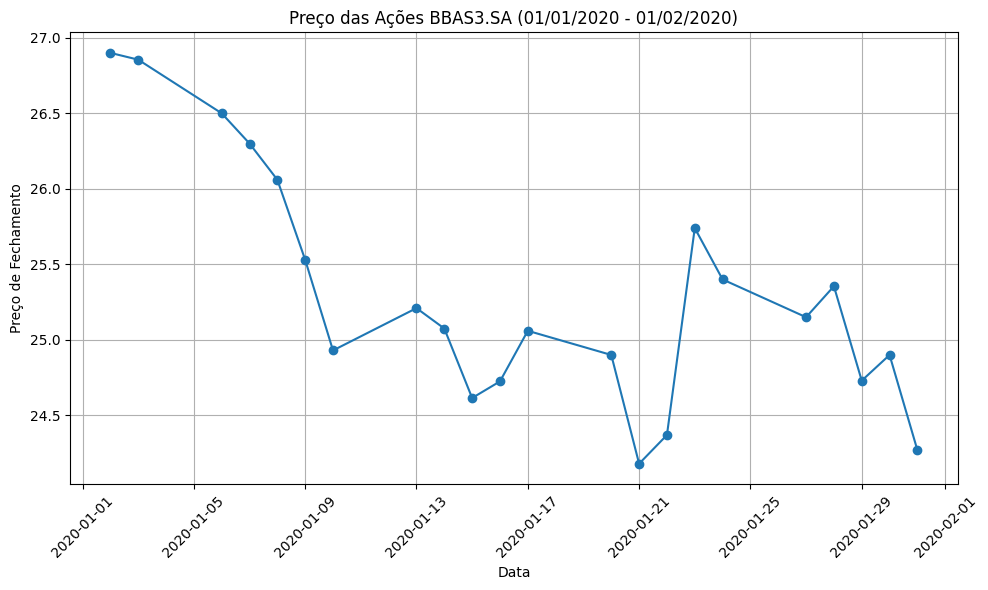

================================ Human Message =================================

Faca uma analise das acoes do Banco do Brasil (BBAS3.SA) no periodo de 2020-01-01 ate 2020-02-01, plote um grafico para sustentar sua analise use a ferramenta python_repl parra isso
================================== Ai Message ==================================
Tool Calls:
  procurar_dados_acao (64e1351f-d3bf-40b3-8aba-bc0b810b03a5)
 Call ID: 64e1351f-d3bf-40b3-8aba-bc0b810b03a5
  Args:
    data_inicio: 2020-01-01
    ticker: BBAS3.SA
    data_fim: 2020-02-01
================================= Tool Message =================================
Name: procurar_dados_acao

                                Open       High        Low      Close  \
Date                                                                    
2020-01-02 00:00:00-03:00  26.674999  26.985001  26.584999  26.900000   
2020-01-03 00:00:00-03:00  26.549999  26.955000  26.424999  26.855000   
2020-01-06 00:00:00-03:00  26.700001  26.700001  26.2

In [77]:
input_message = {"role": "user", "content": "Faca uma analise das acoes do Banco do Brasil (BBAS3.SA) no periodo de 2020-01-01 ate 2020-02-01, plote um grafico para sustentar sua analise use a ferramenta python_repl parra isso"}


response = agent_executor.invoke({"messages": [input_message]})

for message in response["messages"]:
    message.pretty_print()

Conseguimos um resultado favoravel, mas vale apontar que a api do google retornou alguns internal erros com o mesmo prompt. Acho que eh questao de ser algo muitoo custoso.

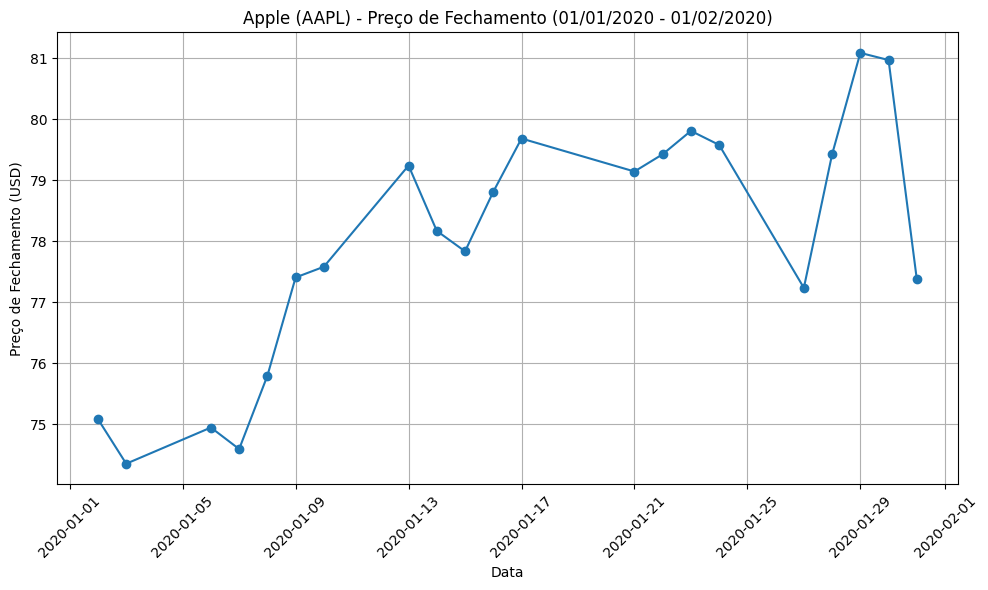

================================ Human Message =================================

Faca uma analise detalhada das acoes da Apple no periodo de 2020-01-01 ate 2020-02-01, plote um grafico para sustentar sua analise use a ferramenta python_repl parra isso
================================== Ai Message ==================================
Tool Calls:
  procurar_dados_acao (a51cf550-01dc-467a-8f67-03c134732238)
 Call ID: a51cf550-01dc-467a-8f67-03c134732238
  Args:
    data_inicio: 2020-01-01
    ticker: AAPL
    data_fim: 2020-02-01
================================= Tool Message =================================
Name: procurar_dados_acao

                                Open       High        Low      Close  \
Date                                                                    
2020-01-02 00:00:00-05:00  74.059998  75.150002  73.797501  75.087502   
2020-01-03 00:00:00-05:00  74.287498  75.144997  74.125000  74.357498   
2020-01-06 00:00:00-05:00  73.447502  74.989998  73.187500  74.94999

In [78]:
input_message = {"role": "user", "content": "Faca uma analise detalhada das acoes da Apple no periodo de 2020-01-01 ate 2020-02-01, plote um grafico para sustentar sua analise use a ferramenta python_repl parra isso"}


response = agent_executor.invoke({"messages": [input_message]})

for message in response["messages"]:
    message.pretty_print()

apenas para comparar os graficos

<Axes: xlabel='Date'>

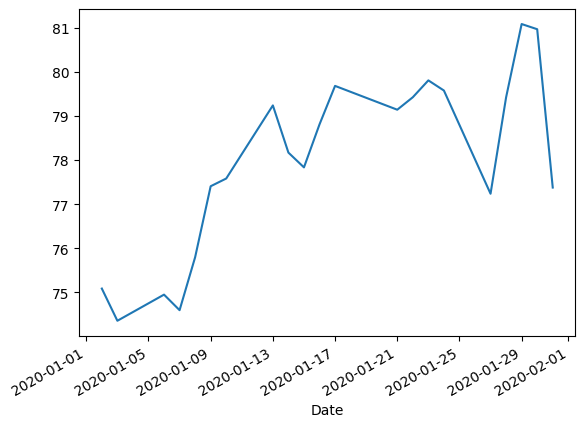

In [86]:
appl = yf.Ticker(ticker="AAPL")
history = appl.history(start="2020-01-01",end="2020-02-01",auto_adjust=False)

history['Close'].plot()

Os graficos estao batendo!